<a href="https://colab.research.google.com/github/Iriansr/GrapheneQNR/blob/master/testing_zz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for functional study of dependence between vacancies, impurities and conductance in ZZGNR
## For use (i=0,ø,1 for systems 0,1,2):
- Change longitude and width of the 3 systems changing the code:
```
# syst(i), leads = make_system0(l=10,w = 5, pot = 0.1)
```
- Set vacancies with the code:
```
# del systi[ai(2,1)]
```
- Set impurities with the code (here we use Silicon based on *Ervasti, Mikko M. et al. “Silicon and Silicon-Nitrogen Impurities in Graphene: Structure, Energetics, and Effects on Electronic Transport.” Physical Review B 92.23 (2015): n. pag. Crossref. Web.*):
```
syst[b(1,5)] = 0.0763
syst[b(1,5),a(1,5)] = -0.3933
syst[b(1,5),a(1,6)] = -0.3933
syst[b(1,5),a(0,6)] = -0.3933
print("Silicon in system 1 at a(1,7)")
```
- For LDoS, set the energies for the plotting with (num_vecs will increase the accuracy of calculations but it will decrease performance; num_vecs = 100 is recomended):
```
zero_ldosi = local_dosi(energy=0)
mid_ldosi = local_dosi(energy=0.5)
fin_ldosi = local_dosi(energy=1)
```

## Results obtained for further analysis with other libraries/languajes:
- position0.csv : csv-format file with positions of the atoms in the lattice.
- datai.csv : csv-format files with conductance for each systems.


In [5]:
!pip install kwant
from math import pi, sqrt, tanh
from matplotlib import pyplot as plt
import kwant
import numpy as np
from numpy import savetxt
import csv
import pandas as pd
import os


Generating and finalizing three systems:

Silicon in system 1 at a(1,7)
Sitio borrado en sistema : a(2,1)
Sub-lattice A: 

[(-3, 6), (-3, 7), (-2, 4), (-2, 5), (-2, 6), (-2, 7), (-1, 2), (-1, 3), (-1, 4), (-1, 5), (-1, 6), (-1, 7), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (9, 1), (9, 2)]
Sub-lattice B: 

[(-3, 6), (-2, 4), (-2, 5), (-2, 6), (-1, 2), (-1, 3), (-1, 4), (-1, 5), (-1, 6), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6),

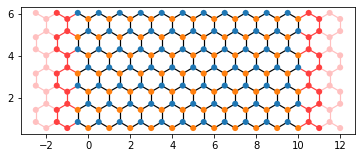

System 2:


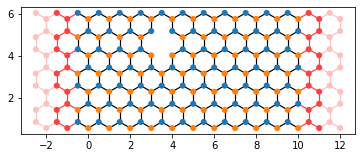

In [6]:
# define lattices and sublattices
graphene = kwant.lattice.honeycomb(norbs=1)   # modified lattice
graphene0 = kwant.lattice.honeycomb(norbs=1)  # pure lattice; from now on 0 at the end means no vacants.
graphene1 = kwant.lattice.honeycomb(norbs=1)
a0, b0 = graphene0.sublattices
a, b = graphene.sublattices
a1 ,b1 = graphene1.sublattices

# system 1
syst0= kwant.Builder()
def make_system0(l = 10, w = 10, pot = 0.1):
    def nrb(pos):
        (x,y) = pos
        return 0 <= x <= l and 0.5 <= y <=w
    def potential(site):                        
        (x,y) = site.pos
        return pot    
    syst0[graphene0.shape(nrb, (0, 0))] = potential 
    hoppings = ()
    syst0[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
    syst0[graphene.neighbors()] = -1
    sym0 = kwant.TranslationalSymmetry((-1,0))      
    sym0.add_site_family(a0, other_vectors= [(-1,2)]) 
    sym0.add_site_family(b0, other_vectors= [(-1,2)]) 
    lead = kwant.Builder(sym0)
    def lead_shape(pos):
        (x,y) = pos
        return 0.5 <= y <= w
    lead[graphene0.shape(lead_shape, (1,1))] = pot
    lead[graphene0.neighbors()] = -1
    return syst0, [lead, lead.reversed()]
syst0, leads = make_system0(l=10,w = 6.5, pot = 0.1)
# lists, % preparation etc.
nods_list = list(syst0.sites())    
df = pd.DataFrame(nods_list)
df.columns = ['Lattice', 'site']
df = df.astype({"Lattice": str})
dfb0 = df.loc[df['Lattice'] == '<Monatomic lattice 1 with 1 orbitals>']
b0_site = dfb0.iloc[:,1:].values
dfa0 = df.loc[df['Lattice'] == '<Monatomic lattice 0 with 1 orbitals>']
a0_site = dfa0.iloc[:,1:].values
a0_list = []
b0_list = []
for i in range (0,len(a0_site)): a0_list.append(tuple(a0_site[i][0]))
for i in range (0,len(b0_site)): b0_list.append(tuple(b0_site[i][0]))
# finalization
for lead in leads:
    syst0.attach_lead(lead)
syst0 = syst0.finalized()
conductance0 = []
energies = np.linspace(0, 1.2)
for energy in energies:
    smatrix0 = kwant.smatrix(syst0, energy)
    conductance0.append(smatrix0.transmission(0,1))
savetxt('conductance0.csv', conductance0, delimiter=',')
position0 = np.array([syst0.pos(i) for i in range(syst0.graph.num_nodes)])
savetxt('position0.csv', position0, delimiter=',')

    # system 2
syst = kwant.Builder()
def make_system(l = 10, w = 10, pot = 0.1):
    def nrb(pos):
        (x,y) = pos
        return 0 <= x <= l and 0.5 <= y <=w
    def potential(site):                        
        (x,y) = site.pos
        return pot    
    syst[graphene.shape(nrb, (0, 0))] = potential 
    hoppings = ()
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
    syst[graphene.neighbors()] = -1

# impurities (silicon)
    syst[b(1,5)] = 0.0763
    syst[b(1,5),a(1,5)] = -0.3933
    syst[b(1,5),a(1,6)] = -0.3933
    syst[b(1,5),a(0,6)] = -0.3933
    print("Silicon in system 1 at a(1,7)")
# vacants
    # del syst[a(1,7)]
    # del syst[b(1,6)]
    # del syst[b(2,6)]
    # print("Sitio borrado en sistema 1: a(1,7)")
    sym = kwant.TranslationalSymmetry((-1,0))      
    sym.add_site_family(a, other_vectors= [(-1,2)]) 
    sym.add_site_family(b, other_vectors= [(-1,2)]) 
    lead = kwant.Builder(sym)
    def lead_shape(pos):
        (x,y) = pos
        return 0.5 <= y <= w
    lead[graphene.shape(lead_shape, (1,1))] = pot
    lead[graphene.neighbors()] = -1
    return syst, [lead,lead.reversed()]
syst, leads = make_system(l=10,w = 6.5, pot = 0.1)
for lead in leads:
    syst.attach_lead(lead)
syst = syst.finalized()


# system 3
syst1 = kwant.Builder()
def make_system(l = 10, w = 10, pot = 0.1):
    def nrb(pos):
        (x,y) = pos
        return 0 <= x <= l and 0.5 <= y <=w
    def potential(site):                        
        (x,y) = site.pos
        return pot    
    syst1[graphene1.shape(nrb, (0, 0))] = potential 
    hoppings = ()
    syst1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
    syst1[graphene.neighbors()] = -1
# vacants
    # del syst1[b1(1,5), a1(1,6),a1(1,5), a1(0,7)]
    del syst1[a1(1,5)]
    del syst1[b1(1,5)]
    #del syst1[a1(1,6)]
    #del syst1[a1(0,6)]
    print("Sitio borrado en sistema : a(2,1)")
    sym1 = kwant.TranslationalSymmetry((-1,0))      
    sym1.add_site_family(a1, other_vectors= [(-1,2)]) 
    sym1.add_site_family(b1, other_vectors= [(-1,2)]) 
    lead = kwant.Builder(sym1)
    def lead_shape(pos):
        (x,y) = pos
        return 0.5 <= y <= w
    lead[graphene1.shape(lead_shape, (1,1))] = pot
    lead[graphene1.neighbors()] = -1
    return syst1, [lead,lead.reversed()]
syst1, leads = make_system(l=10,w = 6.5, pot = 0.1)
for lead in leads:
    syst1.attach_lead(lead)
syst1 = syst1.finalized()

## Fucntions for representation

def plot_conductance(syst, energies):
    # transmission as function of energy
    data = []
    data0 = []
    data1 = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)    
        data.append(smatrix.transmission(0, 1))
    for energy in energies:
        smatrix0 = kwant.smatrix(syst0, energy)
        data0.append(smatrix0.transmission(0,1))
    for energy in energies:
        smatrix1 = kwant.smatrix(syst1, energy)
        data1.append(smatrix1.transmission(0,1))

    savetxt('data.csv', data, delimiter=',')   # data for doped lattice
    savetxt('data0.csv', data0, delimiter=',') # data for perfect lattice
    savetxt('data1.csv', data1, delimiter=',') # data for vacant lattice

    plt.figure()
    plt.plot(energies, data, 'b', label = 'doped w/ silicon (1)')
    plt.plot(energies, data0, 'k', label = 'w/o vacants')
    plt.plot(energies, data1, 'g', label = 'w vacants (2)')
    plt.xlabel("Energy [t]")
    plt.ylabel("Conductance [2e^2/h]")
    plt.title('Conductance')
    plt.legend()
    plt.show();

# Bandstructure
def plot_bandstructure(flead, momenta):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]
    plt.figure()
    plt.plot(momenta, energies)
    plt.xlabel("momenta [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.show()

def getKey(item):
     return item[0]
a_sort = sorted(a0_list, key=getKey)
b_sort = sorted(b0_list, key=getKey)
print("Sub-lattice A: \n")
print(a_sort)
print("Sub-lattice B: \n")
print(b_sort)

# Plotting the system
print("System 1:")
kwant.plot(syst);
print("System 2:")
kwant.plot(syst1);

Plotting **Conductance**, **Bandstructure** and **DoS**:



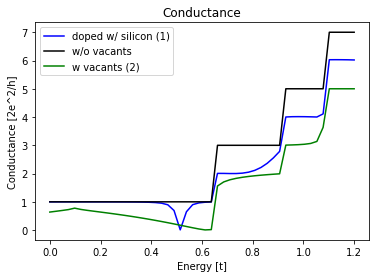

System 1 % difference = 14.099036976917628 % 

System 2 % difference = 46.77797491444444 % 



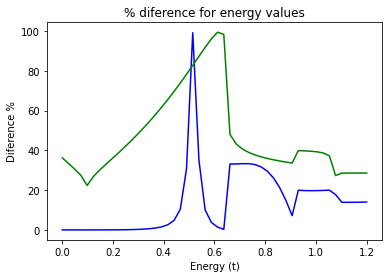

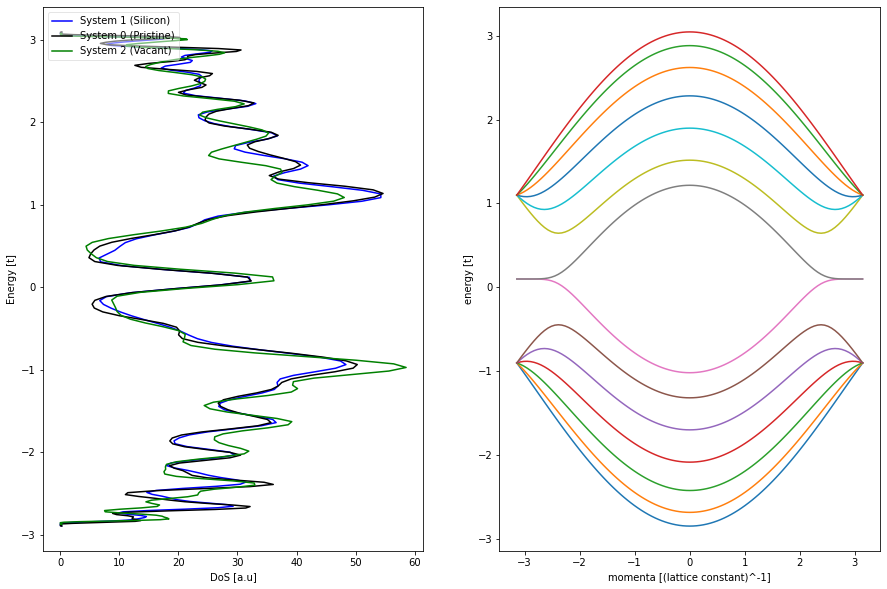

In [9]:
## Plotting conductance
plot_conductance(syst, energies = np.linspace(0, 1.2));

## Plotting band structure of lead 0 (left)
momenta = [-pi + 0.02 * pi * i for i in range(101)]

## comparison of values 
# transforming csv to arrays (len() == 50)
d0_a = np.genfromtxt('data0.csv',delimiter = ',')
d_a = np.genfromtxt('data.csv', delimiter= ',')
d_a1 = np.genfromtxt('data1.csv', delimiter =',')

# substracting arrays so A-B=C and % dif = C/A since d0_a > d_a always
p_dif = np.divide(np.subtract(d0_a,d_a),d0_a)  # C/A
p_dif1 = np.divide(np.subtract(d0_a,d_a1),d0_a)
p_dif[np.isnan(p_dif)]=0
p_dif1[np.isnan(p_dif)]=0                      # replacing nan (0/0) with 0
print("System 1 % difference = " + str(sum(p_dif)*10/5) + " % \n" )
print("System 2 % difference = " + str(sum(p_dif1)*10/5) + " % \n" )
plt.figure()
plt.plot(np.linspace(0, 1.2),p_dif*100, 'b')
plt.plot(np.linspace(0,1.2), p_dif1*100, 'g')
plt.xlabel("Energy (t)")
plt.ylabel("Diference %")
plt.title('% diference for energy values')

## Plotting DoS
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
spectrum = kwant.kpm.SpectralDensity(syst, rng=0)
spectrum0 = kwant.kpm.SpectralDensity(syst0, rng=0)
spectrum1 = kwant.kpm.SpectralDensity(syst1, rng=0)
energies, densities = spectrum()
energies0, densities0 = spectrum0()
energies1, densities1 = spectrum1()
plt.plot(densities.real, energies,'b', label = "System 1 (Silicon)")
plt.plot(densities0.real, energies0, 'k', label = "System 0 (Pristine)")
plt.plot(densities1.real, energies1, 'g', label = "System 2 (Vacant)")
plt.legend(loc=2, framealpha=0.5)
plt.xlabel("DoS [a.u]")
plt.ylabel("Energy [t]")
plt.subplot(1,2,2)
bands = kwant.physics.Bands(syst.leads[0])
energies = [bands(k) for k in momenta]
plt.plot(momenta, energies)
plt.xlabel("momenta [(lattice constant)^-1]")
plt.ylabel("energy [t]")
plt.savefig('DoS.png')
plt.show()

# Plot several local density of states maps in different subplots
def plot_ldos(syst, densities):
    fig, axes = plt.subplots(1, len(densities), figsize=(7*len(densities), 7))
    for ax, (title, rho) in zip(axes, densities):
        kwant.plotter.density(syst, rho.real, ax=ax)
        ax.set_title(title)
        ax.set(adjustable='box', aspect='equal')
    plt.show()

**LDoS** for each system.

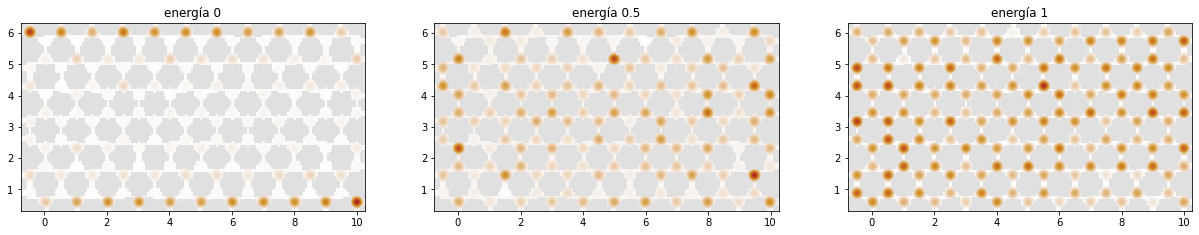

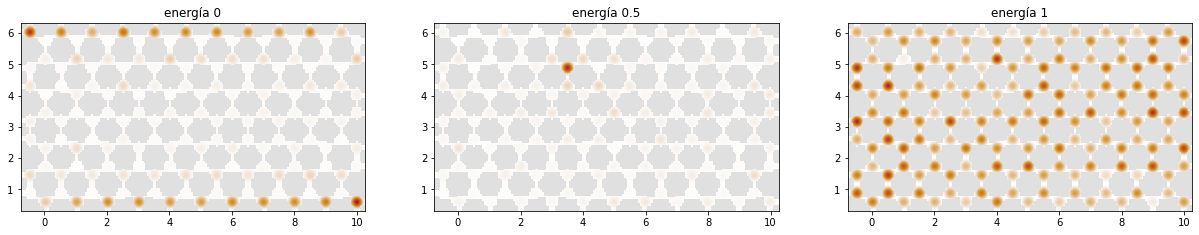

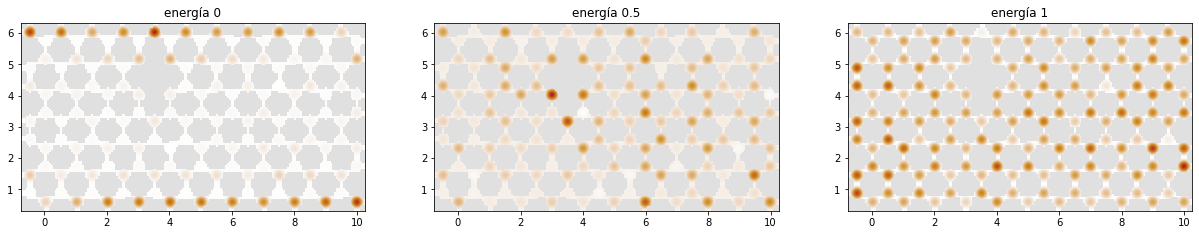

In [20]:
def plot_ldos(syst, densities):
    fig, axes = plt.subplots(1, len(densities), figsize=(7*len(densities), 7))
    for ax, (title, rho) in zip(axes, densities):
        kwant.plotter.density(syst, rho.real, ax=ax)
        ax.set_title(title)
        ax.set(adjustable='box', aspect='equal')
    plt.show()

# I set a dictionary for saving kwant.kpm.SpectralDensity()
d_ldos= {}
systems = [syst0, syst, syst1]
for i in range(len(systems)):
  d_ldos[i] = np.ndarray(1)
for key in d_sis.keys():
  density_operator = kwant.operator.Density(systems[i], sum = False)
  d_ldos[key] = kwant.kpm.SpectralDensity(systems[i], operator = density_operator, rng = 0, num_vectors = 100)
  plot_ldos(systems[i],[('Energy = 0',d_ldos[key](energy = 0)),
                    ('Energy = 0.5', d_ldos[key](energy = 0.5)),
                    ('Energy 1',d_ldos[key](energy = 1))
  ])  